# Resume Parsing

So basically, we want to create a entity ruler to parse real resume and get the "skills".

But for your assignment, i will ask you to extract education.

## 1. Load data

In [2]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("resume.csv")

In [3]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [42]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "skills.jsonl"

In [43]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [44]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

## 3. Let's try to extract skills from this resume.csv

In [11]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1169,21568833,CONSULTANT Summary Position ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT
1630,15154822,CREATIVE DIRECTOR & FASHION DESIGNER ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL
1542,29998869,DIRECTOR OF FINANCE Summary ...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE
1277,18927233,DIGITAL MARKETING COORDINATOR ...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA
1607,16391949,CASHIER Professional Profile ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL


In [12]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [13]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         MECHANICAL DESIGNER       Professional Profile     \u200b Design Engineer with a proven track record of success. Offer excellence in analytical decision making and product innovation to drive business growth and collaboration.\xa0 An articulate presenter with the ability to communicate technical in'

In [14]:
preprocessing(random_resume[:300])

'mechanical designer professional profile \u200b design engineer prove track record success offer excellence analytical decision making product innovation drive business growth collaboration an articulate presenter ability communicate technical'

In [15]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [16]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1169,21568833,CONSULTANT Summary Position ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant summary position accounting regulat...
1630,15154822,CREATIVE DIRECTOR & FASHION DESIGNER ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,creative director & fashion designer summary p...
1542,29998869,DIRECTOR OF FINANCE Summary ...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE,director of finance summary seasoned certified...
1277,18927233,DIGITAL MARKETING COORDINATOR ...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,digital marketing coordinator skill profession...
1607,16391949,CASHIER Professional Profile ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,cashier professional profile responsible cashi...


## 4. Let's really extract skills!!

In [23]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [24]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
1169,21568833,CONSULTANT Summary Position ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant summary position accounting regulat...


In [25]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [26]:
df_resume.Skills.iloc[0]

[]

## 5. Visualization

Which skills is most important in information management?

In [27]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [28]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(53, 6)

In [29]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [30]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [31]:
counting

OrderedDict()

<BarContainer object of 0 artists>

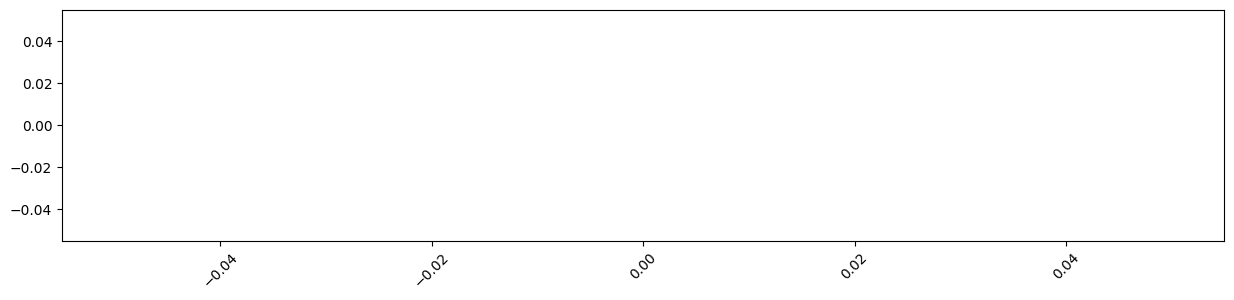

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [33]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [34]:
doc = nlp(text)

In [35]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [36]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. Let's load the PDF - add some realism

In [37]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("../data/word2vec.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

FileNotFoundError: [Errno 2] No such file or directory: '../data/word2vec.pdf'

In [38]:
text = preprocessing(text)

In [39]:
doc = nlp(text)

In [40]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [47]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'complex system', 'nlp', 'speech recognition', 'language model'}
